## Age and Gender Detection System.


### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Compose

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix


# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cuda


## Load the dataset

In [3]:
!unzip -q "/kaggle/working/UTKFace.zip"

replace UTKFace/16_0_0_20170102234641453.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
UTKFace = 'UTKFace'
genders = []
ages = []
filenames = os.listdir(UTKFace)

images = [cv2.imread(UTKFace + '/' + image)
              for image in os.listdir(UTKFace)]

images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

images = [cv2.resize(image, (256,256)) for image in images]

for image in filenames:
  image_path = os.path.join(UTKFace, image)
  labels = image.split('_')
  genders.append(int(labels[1]))
  ages.append(int(labels[0]))


In [3]:
print(f'ages: {len(ages)}, genders: {len(genders)}')

ages: 19599, genders: 19599


[0 1]


([<matplotlib.patches.Wedge at 0x7ba8548c1ed0>,
 [Text(-0.1213273408257444, 1.093288468963317, '0'),
  Text(0.1213274431867978, -1.0932884576038269, '1')])

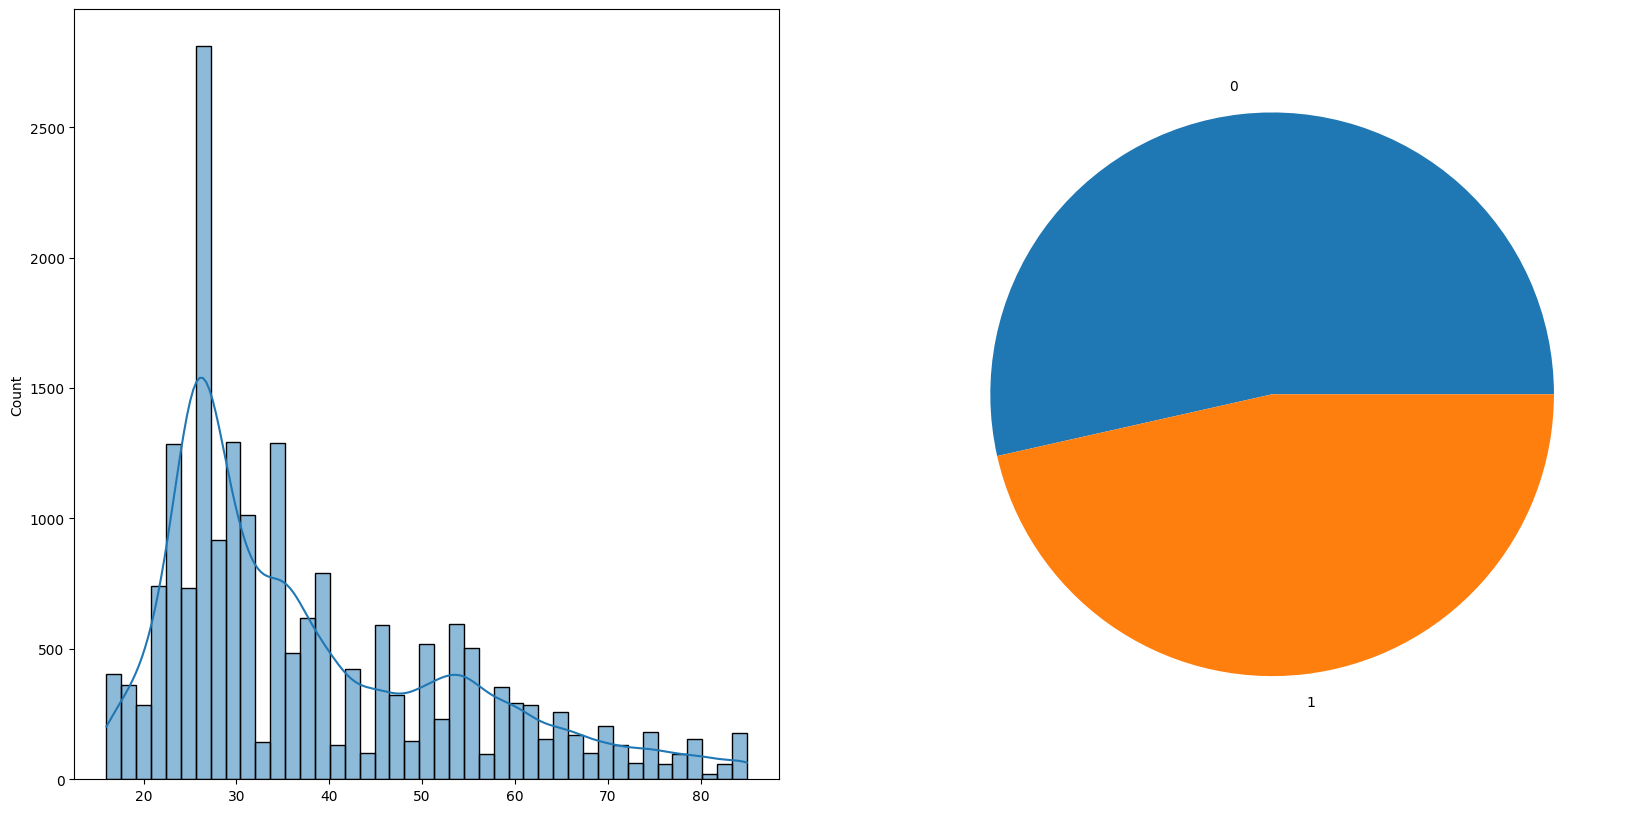

In [4]:
images = np.array(images)
genders = np.array(genders)
ages = np.array(ages)
print(np.unique(genders))
fig, ax = plt.subplots(1, 2, figsize = (20,10))
sns.histplot(ages,kde = True, ax = ax[0])
l, c = np.unique(genders, return_counts=True)
ax[1].pie(c, labels = l)

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
class WideAndDeepModel(Model):
  def __init__(self, model_type, **kwargs):
    super().__init__(**kwargs) # handles standard args (e.g., name)
    self.conv1 = Conv2D(filters = 64,kernel_size = (5, 5),input_shape = (256, 256, 1),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')
    self.conv2 = Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')
    self.conv3 = Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')
    self.conv4 = Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')
    self.pool = MaxPooling2D(pool_size = (2, 2))
    self.linear1 = Dense(512,activation='relu',kernel_initializer='he_normal',)
    if model_type == 'gender':
        self.linear2 = Dense(2,activation='softmax')
    else:
        self.linear2 = Dense(1)
    self.batch_norm = BatchNormalization()
    self.drop = Dropout(0.6)
  def call(self, xyxy):
    input = xyxy
    c1 = self.pool(self.batch_norm(self.conv1(input)))
    c2 = self.pool(self.conv2(c1))
    c3 = self.pool(self.conv3(c2))
    c4 = self.pool(self.conv4(c3))
    flattened = Flatten()(c4)
    l1 = self.linear1(flattened)
    d = self.drop(l1)
    output = self.linear2(d)
    return output
#model = WideAndDeepModel()

In [7]:
def create_model(model_type, images, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.7, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.34, shuffle=True, random_state=42)
    model = WideAndDeepModel(model_type)
    if model_type == 'age':
        loss = 'mean_absolute_error'
        metrics = ['MeanSquaredError']
    else:
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    model.compile(
    loss = loss,
    optimizer = 'rmsprop',
    metrics = metrics
    )

    X_train = X_train.astype('float16').reshape((X_train.shape[0],256,256,1))
    X_val = X_val.astype('float16').reshape((X_val.shape[0],256,256,1))
    X_test = X_test.astype('float16').reshape((X_test.shape[0],256,256,1))
    
    if model_type == 'gender':
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        y_test = to_categorical(y_test, 2)
    return model, X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
model, X_train, y_train, X_val, y_val, X_test, y_test = create_model('gender', images, genders)
#model, X_train, y_train, X_val, y_val, X_test, y_test = create_model('age', images, ages)
checkpoint_cb = ModelCheckpoint("gender.tf", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
    validation_data = (X_val, y_val)
    , batch_size=16, epochs=30, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
368/368 [==============================] - 57s 148ms/step - loss: 3.6773 - accuracy: 0.5412 - val_loss: 0.5328 - val_accuracy: 0.7498
Epoch 2/30
368/368 [==============================] - 48s 130ms/step - loss: 0.4953 - accuracy: 0.8037 - val_loss: 0.3602 - val_accuracy: 0.8700
Epoch 3/30
368/368 [==============================] - 45s 123ms/step - loss: 0.3563 - accuracy: 0.8578 - val_loss: 0.4134 - val_accuracy: 0.8682
Epoch 4/30
368/368 [==============================] - 48s 132ms/step - loss: 0.3070 - accuracy: 0.8806 - val_loss: 0.2879 - val_accuracy: 0.8946
Epoch 5/30
368/368 [==============================] - 45s 123ms/step - loss: 0.2765 - accuracy: 0.8995 - val_loss: 0.2935 - val_accuracy: 0.8879
Epoch 6/30
368/368 [==============================] - 45s 123ms/step - loss: 0.2618 - accuracy: 0.9061 - val_loss: 0.3395 - val_accuracy: 0.8881
Epoch 7/30
368/368 [==============================] - 45s 123ms/step - loss: 0.2649 - accuracy: 0.9129 - val_loss: 0.3785 - val_ac

In [12]:
model.evaluate(X_test, y_test)

146/146 [==============================] - 7s 44ms/step - loss: 0.2955 - accuracy: 0.9003


[0.2955383360385895, 0.9003215432167053]

In [9]:
model2.evaluate(X_test, y_test)

146/146 [==============================] - 9s 53ms/step - loss: 7.7858 - mean_squared_error: 108.0546


[7.785823822021484, 108.05455780029297]